In [3]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

import os
import sys  
import numpy as np 
import matplotlib.pyplot as plt 

fdb_pkg = os.path.join(os.getcwd(), "..")
if fdb_pkg not in sys.path: sys.path.insert(0, fdb_pkg)

import pandas as pd
from ml_finite_difference_bem import simulate, param, result, utils
pp, fd = utils.pp, utils.fd

In [4]:
# ---------------------------------------------------
# Get reference data
# ---------------------------------------------------

ep_fpath = os.path.join(os.getcwd(), "..", "data", "simple_ep")
epw_fpath = os.path.join(os.getcwd(), "..", "data", "chicago.epw")
epdf = result.get_ep_df(ep_fpath)
ewdf = result.get_epw_df(epw_fpath)
epdf["qsy"] = epdf["qht"] + epdf["qcl"]

In [5]:
# ---------------------------------------------------
# Setup building parameters 
# Note: These can be pulled from the feature matrix  
# ---------------------------------------------------

# Geometry 
wwr = 0.4
A_wi = 3 * 8 * wwr 
A_wa = (3 * 8 * 4)  # total wall area
A_flr = 84 
V_flr = A_flr * 3  

# Constructions
wall_mat = param.OpaqueMaterial("mass_wall_mat")
wall_mat.k = 1.3101
wall_mat.a_lw = 0.9 
wall_mat.a_sw = 0.7
wall_mat.dens = 2240.26044
wall_mat.Cp = 836.26
wall_mat.l = 0.2032
wall = param.OpaqueElement("mass_wall_ele")
wall.area = A_wa 
wall.materials = [wall_mat]

floor = param.OpaqueElement("mass_floor_ele")
floor.area = A_flr


# Internal loads 
qlight = 11.5 # W/m2
qequip = 6.7  # W/m2

# Schedule
sched = np.ones(24).astype(int)


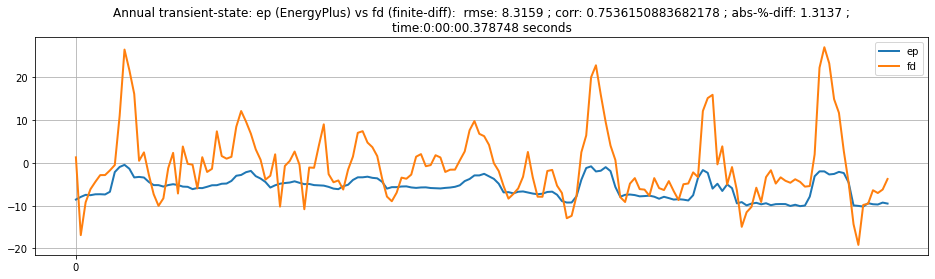

In [6]:
# ---------------------------------------------------
# Example 1: Transient-state simulation
# ---------------------------------------------------

# Simulate 
sim = param.SimParam(day=1, month=1, period=24*7, dt=3600)
fddf, tdelta = simulate.transient(
    [wall, floor], sim, ewdf, result.get_fd_df(sim), vf=(0.25, 1), record=True)

# Setup plotting constants
_, ax = plt.subplots(1, 1, figsize=(16, 4), sharey=True)
plt_er = result.fx_plt_err(result.RMSE + result.CORR + result.ABS_PERCENT) 
plt_title = "Annual transient-state: ep (EnergyPlus) vs fd (finite-diff)"
# Plot against equivalent EP results and compute error
df = pd.DataFrame({'ep': epdf['qwa'], 'fd': fddf['q_wa']})
ax = plt_er(sim, df.ep, df.fd, linewidth=0.5 if sim.period == 8760 else 2, ax=ax)
ax.set_xticks(np.arange(sim.start_hr, sim.end_hr, 14*24)); ax.grid(True); 
#ax.set_yticks( np.arange(-20, 20, 2))
#ax.set_xlim((sim.s_hr, sim.e_hr)); ax.set_ylim((-20, 20));
ax.set_title("{}: {}\ntime:{} seconds".format(
       plt_title, ax.get_title(), tdelta));

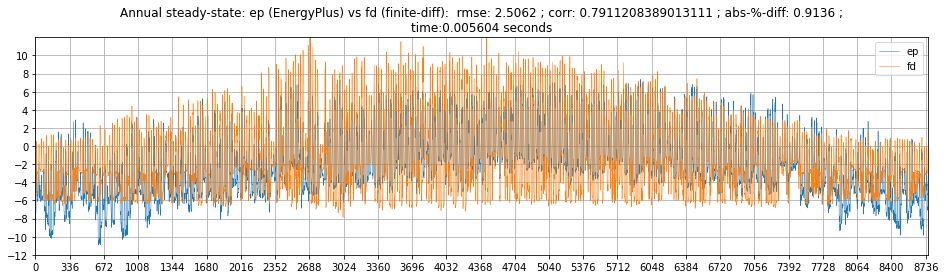

In [8]:
# ---------------------------------------------------
# Example 2a: Steady-state simulation
# ---------------------------------------------------

# Simulate
sim = param.SimParam(day=1, month=1, period=8760, dt=3600)
df, tdelta = simulate.steady([wall, floor], sim, ewdf, vf=(0.25, 1))
df 

# Setup plotting constants
_, ax = plt.subplots(1, 1, figsize=(16, 4))
plt_er = result.fx_plt_err(result.RMSE + result.CORR + result.ABS_PERCENT)
plt_title = "Annual steady-state: ep (EnergyPlus) vs fd (finite-diff)"
# Plot against equivalent EP results and compute error
df = pd.DataFrame({"ep": epdf.qwa, "fd": df["qdot_wa"]})
ax = plt_er(sim, df.ep, df.fd, ax=ax, linewidth=0.5 if sim.period == 8760 else 2)
ax.set_xticks(np.arange(sim.start_hr, sim.end_hr, 14*24)); ax.grid(True); 
ax.set_yticks(np.arange(-12, 12, 2)); ax.set_xlim((sim.start_hr, sim.end_hr)); ax.set_ylim((-12, 12))
ax.set_title("{}: {}\ntime:{} seconds".format(
       plt_title, ax.get_title(), tdelta));


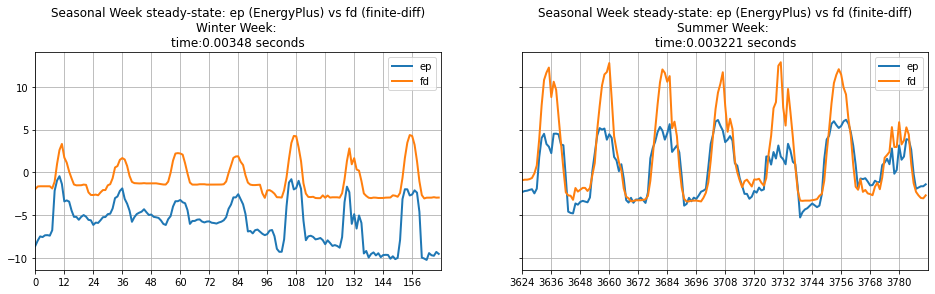

In [9]:
# ---------------------------------------------------
# Example 2b: Steady-state simulation
# ---------------------------------------------------

# Setup plotting constants
fig, axes = plt.subplots(1, 2, figsize=(16, 4), sharey=True)
per_dict = {1:"Winter Week", 6:"Summer Week"}
plt_er = result.fx_plt_err(result.RMSE + result.CORR + result.ABS_PERCENT)
plt_title = "Seasonal Week steady-state: ep (EnergyPlus) vs fd (finite-diff)"

for ax, mth in zip(axes, per_dict.keys()):

    # Simulate
    sim = param.SimParam(day=1, month=mth, period=24*7, dt=3600)
    df, tdelta = simulate.steady([wall, floor], sim, ewdf, vf=(0.25, 0.5))
    
    # Plot against equivalent EP results and compute error
    df = pd.DataFrame({"ep": epdf.qwa, "fd": df.qdot_wa})
    #ax = plt_er(sim, df.ep, df.fd, ax=ax, linewidth=0.5 if sim.period == 8760 else 2)
    ax = result.fx_plt()(sim, df, ax=ax, linewidth=2) 
    ax.set_xticks(np.arange(sim.start_hr, sim.end_hr, 12));
    # ax.set_yticks(np.arange(-12, 12, 2)); 
    ax.set_xlim((sim.start_hr, sim.end_hr)); ax.grid(True)
    ax.set_title("{}\n{}: {}\ntime:{} seconds".format(
        plt_title, per_dict[mth], ax.get_title(), tdelta))
